In [1]:
import helper as hp
import glob
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import re
import fnmatch
import seaborn as sns
from collections import MutableMapping 

# Load and organize data

In [2]:
filenames = glob.glob('FACS-data/*.csv')
filenames.sort()

Load dataframes. NB: there is a selection for events with more than X events.

In [3]:
li = []
ids = set()


for filename in filenames:
    
    name = filename.replace('FACS-data/export_', '')
    
    #Date and replicate number
    replicate_number = -999
    if '2018-03' in name:
        replicate_number = 1
        name = name.replace('2018-03', '')
    elif '2018-05' in name:
        replicate_number = 2
        name = name.replace('2018-05', '')
    elif '2019-02' in name:
        replicate_number = 3
        name = name.replace('2019-02', '')
    else:
        print("=========")
        print("Date not found: ")
        print(name)
        
    #Timepoint
    time_point = -999
    if '24h' in name:
        time_point = 24
    elif '48h' in name:
        time_point = 48
    elif '72h' in name:
        time_point = 72
    elif '96h' in name:
        time_point = 96
    elif '120h' in name:
        time_point = 120
    elif '144h' in name:
        time_point = 144
    else:
        print("=========")
        print("Time point not found: ")
        print(name)
    name = name.replace(str(time_point) + 'h', '')
        
    #Treatment
    treatment = -999
    if 'siSTK' in name:
        treatment = 'siSTK'
    elif ('last-' in name) or ('lat-' in name):
        treatment = 'blast-'
    elif ('last+' in name) or ('lat+' in name):
        treatment = 'blast+'
    elif 'siBRCA2' in name:
        treatment = 'siBRCA2'
    elif 'siGFP' in name:
        treatment = 'siGFP'
    elif 'siSCR' in name:
        treatment = 'siSCR'
    elif 'siMisNeg' in name:
        treatment = 'siMisNeg'
    elif 'siRAD51' in name:
        treatment = 'siRAD51'
    elif 'siPALB2' in name:
        treatment = 'siPALB2'
    else:
        print("=========")
        print("Treatment not found: ")
        print(name)   
    
    #Technical Replicate
    technical_replicate = 0
    if fnmatch.fnmatch(name, "*_10??_*") or fnmatch.fnmatch(name, "*_010??_*"):
        technical_replicate = 1
    elif fnmatch.fnmatch(name, "*_20??_*") or fnmatch.fnmatch(name, "*_020??_*"):
        technical_replicate = 2  
    elif fnmatch.fnmatch(name, "*_1_*"):
        print("Technical replicate _1_: " + filename)
        technical_replicate = 3
    elif fnmatch.fnmatch(name, "*_2_*"):
        print("Technical replicate _2_: " + filename)
        technical_replicate = 4
    else:
        print("Technical replicate not recognized: " + filename)
        
    unique_id = treatment + str(time_point) + str(replicate_number) + str(technical_replicate)
    if unique_id in ids:
        print("Id not unique for " + filename)
    else:
        ids.add(unique_id)
    
    df = pd.read_csv(filename, converters = {'SSC':int, 'FSC':int, 'FSCW':int, 'BluFL1':float})
    
    #Select samples with more than X events
    if(len(df) < 1000):
        continue
    
    df.insert(0, 'Treatment', treatment)
    df.insert(0, 'Time Point', time_point)
    df.insert(0, 'Biological Replicate', replicate_number)
    df.insert(0, 'Technical Replicate', technical_replicate)
    
    #Blinding the analysis
    if treatment == 'siBRCA2' or treatment == 'siRAD51' or treatment == 'siPALB2':
        continue
    
    li.append(df)
    

frame = pd.concat(li, axis=0, ignore_index=True, sort=False)

In [4]:
frame.drop(['BluFL2', 'BluFL3', 'BluFL4', 
            'RedFL1', 'VioFL1', 'VioFL2',
            'APC-Cy7-A', 'APC-Cy7-H', 'APC-Cy7-W',
            'FITC-A', 'FITC-W', 
            'PerCP-Cy5-5-H', 'PerCP-Cy5-5-W', 
            'TIME', 'Time'], axis=1, inplace = True)

In [5]:
#frame.head()

In [6]:
#frame.describe()

# Apply selection

Set test sample

In [7]:
test_time_point = 72
test_biological_replicate = 2
test_technical_replicate = 1
test_treatment = 'siGFP'

FSC-SSC graph

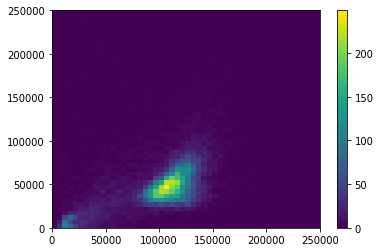

14494


In [8]:
df_sel = frame[(frame['Time Point'] == test_time_point) & 
               (frame['Biological Replicate'] == test_biological_replicate ) &
               (frame['Technical Replicate'] == test_technical_replicate) & 
               (frame['Treatment'] == test_treatment)]

hp.plot_sel(df_sel, x_var = 'FSC', y_var = 'SSC')
print (len(df_sel))

Cell selection: FSC-SSC cut

In [9]:
frame_after_cellsel = frame[((frame['SSC'] > 10000) & (frame['SSC'] < 100000) & (frame['Biological Replicate'] == 2)) |
                            ((frame['SSC'] > 30000) & (frame['SSC'] < 100000) & (frame['Biological Replicate'] == 3))]
frame_after_cellsel = frame_after_cellsel[((frame_after_cellsel['FSC'] > 70000) & (frame_after_cellsel['FSC'] < 200000) & (frame_after_cellsel['Biological Replicate'] == 2)) |
                                          ((frame_after_cellsel['FSC'] > 100000) & (frame_after_cellsel['FSC'] < 250000) & (frame_after_cellsel['Biological Replicate'] == 3))]

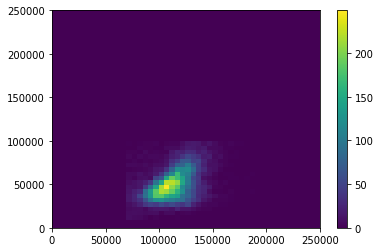

11985


In [10]:
df_sel = frame_after_cellsel[(frame_after_cellsel['Time Point'] == test_time_point) & 
                             (frame_after_cellsel['Biological Replicate'] == test_biological_replicate ) &
                             (frame_after_cellsel['Technical Replicate'] == test_technical_replicate) & 
                             (frame_after_cellsel['Treatment'] == test_treatment)]

hp.plot_sel(df_sel, x_var = 'FSC', y_var = 'SSC')
print (len(df_sel))

FSC-FSCW graph

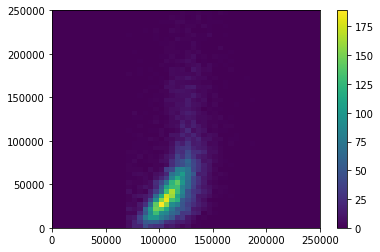

In [11]:
df_sel = frame_after_cellsel[(frame_after_cellsel['Time Point'] == test_time_point) & 
               (frame_after_cellsel['Biological Replicate'] == test_biological_replicate ) &
               (frame_after_cellsel['Technical Replicate'] == test_technical_replicate) & 
               (frame_after_cellsel['Treatment'] == test_treatment)]


hp.plot_sel(df_sel, x_var = 'FSC', y_var = 'FSCW')
#range = [[0,250000],[0,250000]]

single cells selection: FSCW cut

In [12]:
frame_after_singlecellsel = frame_after_cellsel[(frame_after_cellsel['FSCW'] < 100000)]

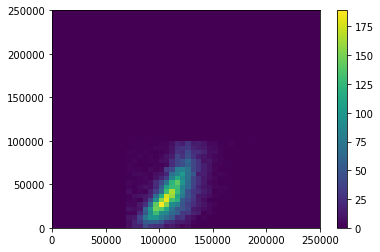

10494


In [13]:
fig, ax = plt.subplots() 

df_sel = frame_after_singlecellsel[(frame_after_singlecellsel['Time Point'] == test_time_point) & 
                                   (frame_after_singlecellsel['Biological Replicate'] == test_biological_replicate ) &
                                   (frame_after_singlecellsel['Technical Replicate'] == test_technical_replicate) & 
                                   (frame_after_singlecellsel['Treatment'] == test_treatment) 
                                   ]

hp.plot_sel(df_sel, x_var = 'FSC', y_var = 'FSCW')
print(len(df_sel))

In [14]:
apply_frac_sel = False

if apply_frac_sel:
    frame_after_singlecellsel_50 = hp.sel_events_based_on_remaining_frac(frame_after_cellsel, frame_after_singlecellsel, 0.5)
else:
    frame_after_singlecellsel_50 = frame_after_singlecellsel.copy()

In [15]:
df_sel = frame_after_singlecellsel_50[(frame_after_singlecellsel_50['Time Point'] == test_time_point) & 
                                   (frame_after_singlecellsel_50['Biological Replicate'] == test_biological_replicate ) &
                                   (frame_after_singlecellsel_50['Technical Replicate'] == test_technical_replicate) & 
                                   (frame_after_singlecellsel_50['Treatment'] == test_treatment) 
                                   ]

#plot_sel(df_sel, x_var = 'RedFL2', y_var = 'BluFL1', 
#         xscale = 'linear', yscale ='log', bins = (50, 100), range_var = [[-100,100],[100,100000]])

#plot_sel(df_sel, x_var = 'RedFL2', y_var = 'BluFL1', 
#         xscale = 'linear', yscale ='linear', range_var = [[-100,100],[-100,1000]])

Set thresholds for RedFL2 and BluFL1:

In [16]:
RedFL2_threshold = 2100
BluFL1_threshold = 280

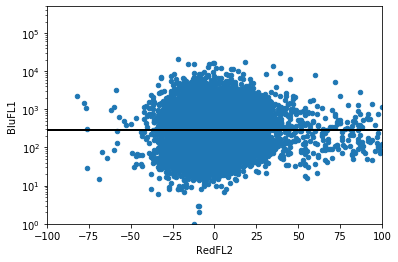

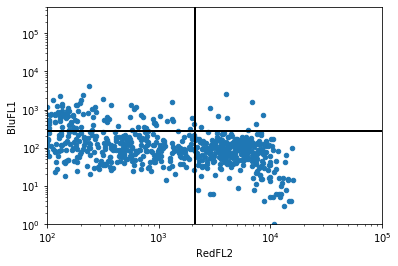

In [17]:
ax_s = df_sel.plot.scatter(x = 'RedFL2', y = 'BluFL1', logx = False, logy = True)
ax_s.set_xlim(-100,100)
ax_s.set_ylim(1,500000)
plt.plot([-100, 100], [BluFL1_threshold, BluFL1_threshold], color='k', linestyle='-', linewidth=2)

ax_s1 = df_sel.plot.scatter(x = 'RedFL2', y = 'BluFL1', logx = True, logy = True)
ax_s1.set_xlim(100,100000)
ax_s1.set_ylim(1,500000)
plt.plot([100, 100000], [BluFL1_threshold, BluFL1_threshold], color='k', linestyle='-', linewidth=2)
plt.plot([RedFL2_threshold, RedFL2_threshold], [1,500000], color='k', linestyle='-', linewidth=2)

In [18]:
frame_alive_green   = frame_after_singlecellsel_50[(frame_after_singlecellsel_50['BluFL1'] > BluFL1_threshold) & (frame_after_singlecellsel_50['RedFL2'] < RedFL2_threshold)]
frame_alive_nogreen = frame_after_singlecellsel_50[(frame_after_singlecellsel_50['BluFL1'] < BluFL1_threshold) & (frame_after_singlecellsel_50['RedFL2'] < RedFL2_threshold)]
frame_dead          = frame_after_singlecellsel_50[ frame_after_singlecellsel_50['RedFL2'] > RedFL2_threshold ]
frame_dead_green    = frame_after_singlecellsel_50[ (frame_after_singlecellsel_50['RedFL2'] > RedFL2_threshold) & (frame_after_singlecellsel_50['BluFL1'] > BluFL1_threshold)]
frame_dead_nogreen  = frame_after_singlecellsel_50[ (frame_after_singlecellsel_50['RedFL2'] > RedFL2_threshold) & (frame_after_singlecellsel_50['BluFL1'] < BluFL1_threshold)]

In [19]:
gb_alive_green   = frame_alive_green.groupby(['Time Point', 'Treatment', 'Biological Replicate', 'Technical Replicate'])
gb_alive_nogreen = frame_alive_nogreen.groupby(['Time Point', 'Treatment', 'Biological Replicate', 'Technical Replicate'])
gb_dead          = frame_dead.groupby(['Time Point', 'Treatment', 'Biological Replicate', 'Technical Replicate'])
gb_dead_green    = frame_dead_green.groupby(['Time Point', 'Treatment', 'Biological Replicate', 'Technical Replicate'])
gb_dead_nogreen  = frame_dead_nogreen.groupby(['Time Point', 'Treatment', 'Biological Replicate', 'Technical Replicate'])

In [20]:
df_counts_gb_alive_green = gb_alive_green.size().reset_index(name='counts')
df_counts_gb_alive_nogreen = gb_alive_nogreen.size().reset_index(name='counts')
df_counts_gb_dead = gb_dead.size().reset_index(name='counts')
df_counts_gb_dead_green = gb_dead_green.size().reset_index(name='counts')
df_counts_gb_dead_nogreen = gb_dead_nogreen.size().reset_index(name='counts')

In [21]:
print(len(df_counts_gb_alive_green))
print(len(df_counts_gb_alive_nogreen))
print(len(df_counts_gb_dead))
print(len(df_counts_gb_dead_green))
print(len(df_counts_gb_dead_nogreen))

109
109
107
104
107


In [22]:
l_dfs = [df_counts_gb_alive_green, 
         df_counts_gb_alive_nogreen, 
         df_counts_gb_dead, 
         df_counts_gb_dead_green, 
         df_counts_gb_dead_nogreen]

l_filled_dfs = hp.fill_missing_samples(l_dfs)

df_counts_gb_alive_green = l_filled_dfs[0]
df_counts_gb_alive_nogreen = l_filled_dfs[1]
df_counts_gb_dead = l_filled_dfs[2]
df_counts_gb_dead_green = l_filled_dfs[3]
df_counts_gb_dead_nogreen = l_filled_dfs[4]

In [23]:
print(len(df_counts_gb_alive_green))
print(len(df_counts_gb_alive_nogreen))
print(len(df_counts_gb_dead))
print(len(df_counts_gb_dead_green))
print(len(df_counts_gb_dead_nogreen))

109
109
109
109
109


In [24]:
df_counts_gb_dead.tail()

Time Point Treatment  Biological Replicate  Technical Replicate  counts
104       144.0     siGFP                   2.0                  2.0      99
105       144.0  siMisNeg                   2.0                  1.0     125
106       144.0  siMisNeg                   2.0                  2.0     121
107       144.0     siSTK                   2.0                  1.0     108
108       144.0     siSTK                   2.0                  2.0     165

In [25]:
df_counts_gb_alive_green['RatioAliveGreen'] = df_counts_gb_alive_green['counts'] / (df_counts_gb_alive_nogreen['counts'] + df_counts_gb_alive_green['counts'])
df_counts_gb_alive_green['RatioAllGreen'] = df_counts_gb_alive_green['counts'] / (df_counts_gb_dead['counts'] + df_counts_gb_alive_nogreen['counts'] + df_counts_gb_alive_green['counts'])
df_counts_gb_alive_green['RatioDead'] = df_counts_gb_dead['counts'] / (df_counts_gb_dead['counts'] + df_counts_gb_alive_nogreen['counts'] + df_counts_gb_alive_green['counts'])

# Final plots

For the catplot below there are two options: <br>
1) Set y = 'counts' and choose among these dataframes for data: df_counts_gb_alive_green, df_counts_gb_alive_nogreen, df_counts_gb_dead, df_counts_gb_dead_green, df_counts_gb_dead_nogreen. <br>
2) Set data to df_counts_gb_alive_green and change y to RatioAliveGreen or RatioAllGreen.

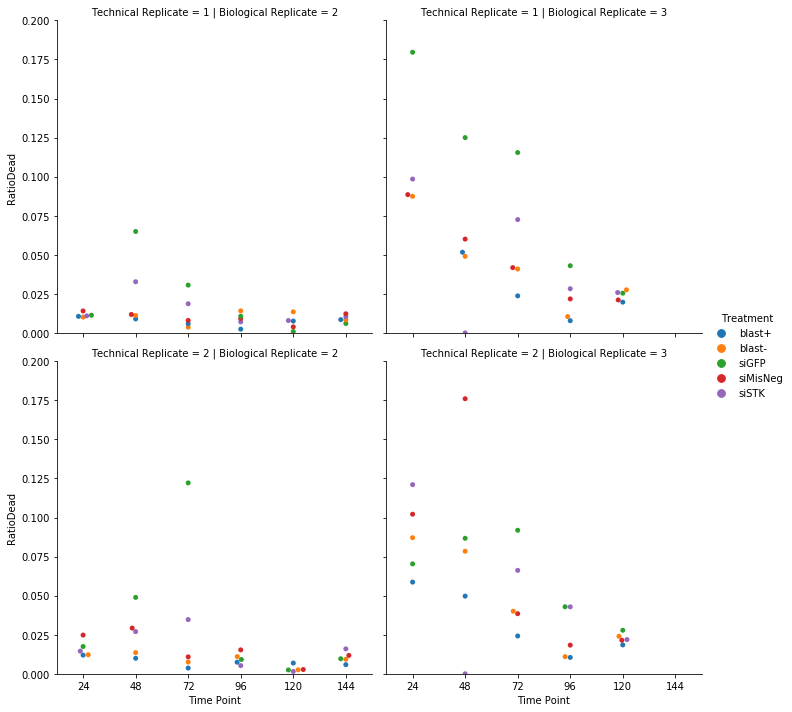

In [26]:
g1 = sns.catplot(row = "Technical Replicate",
                 col = "Biological Replicate",
                 x = "Time Point", 
                 y = "RatioDead", 
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green, 
                 kind = "swarm", 
                 aspect = 1)

g1.set(ylim=(0., 0.2))

Average over the technical replicates first:

In [27]:
df_counts_gb_alive_green_avg_tech = df_counts_gb_alive_green.groupby(['Time Point', 'Treatment', 'Biological Replicate']).mean()
df_counts_gb_alive_green_avg_tech = df_counts_gb_alive_green_avg_tech.reset_index()

In [28]:
#g2 = sns.catplot(x = "Time Point", 
#                 y = "RatioAliveGreen", 
#                 hue = 'Treatment', 
#                 data = df_counts_gb_alive_green_avg_tech, 
#                 kind = "swarm", 
#                 aspect = 3)

In [29]:
#g3 = sns.catplot(x = "Time Point", 
#                 y = "RatioAllGreen", 
#                 hue = 'Treatment', 
#                 data = df_counts_gb_alive_green_avg_tech, 
#                 kind = "swarm", 
#                 aspect = 3)

# Normalised plots

Now let's normalise the ratios with blast+24h:

In [30]:
blast_df = df_counts_gb_alive_green_avg_tech[(df_counts_gb_alive_green_avg_tech['Time Point'] == 24) & (df_counts_gb_alive_green_avg_tech['Treatment'] == 'blast+')]
RatioAliveGreen_2 = float(blast_df[blast_df['Biological Replicate'] == 2]['RatioAliveGreen'])
RatioAliveGreen_3 = float(blast_df[blast_df['Biological Replicate'] == 3]['RatioAliveGreen'])
RatioAllGreen_2 = float(blast_df[blast_df['Biological Replicate'] == 2]['RatioAllGreen'])
RatioAllGreen_3 = float(blast_df[blast_df['Biological Replicate'] == 3]['RatioAllGreen'])

In [31]:
df_counts_gb_alive_green_avg_tech['RatioAliveGreenNorm'] = np.where(df_counts_gb_alive_green_avg_tech['Biological Replicate'] == 2, 
                                                                    df_counts_gb_alive_green_avg_tech['RatioAliveGreen'] / RatioAliveGreen_2, 
                                                                    df_counts_gb_alive_green_avg_tech['RatioAliveGreen'] / RatioAliveGreen_3)
df_counts_gb_alive_green_avg_tech['RatioAllGreenNorm']   = np.where(df_counts_gb_alive_green_avg_tech['Biological Replicate'] == 2, 
                                                                    df_counts_gb_alive_green_avg_tech['RatioAllGreen'] / RatioAllGreen_2, 
                                                                    df_counts_gb_alive_green_avg_tech['RatioAllGreen'] / RatioAllGreen_3)

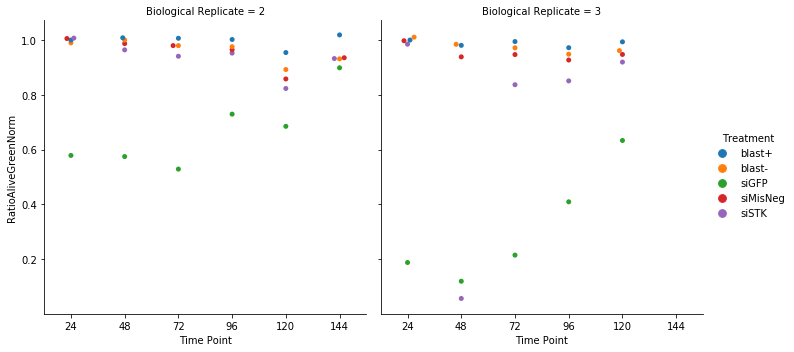

In [32]:
g4 = sns.catplot(x = "Time Point", 
                 y = "RatioAliveGreenNorm", 
                 col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech, 
                 kind = "swarm", 
                 aspect = 1)

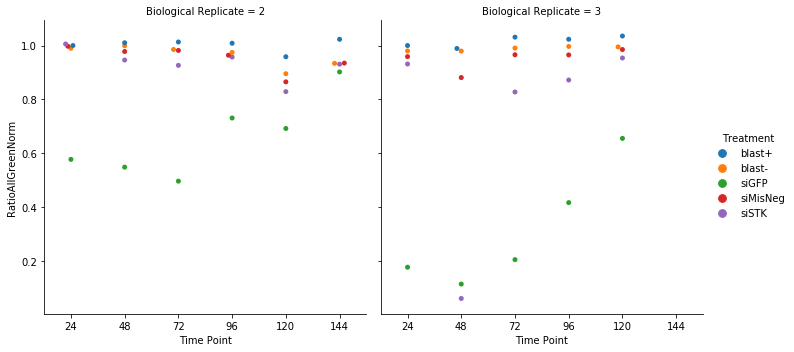

In [33]:
g5 = sns.catplot(x = "Time Point", 
                 y = "RatioAllGreenNorm", 
                 col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech, 
                 kind = "swarm", 
                 aspect = 1)

# HAC loss

In [34]:
df_counts_gb_alive_green_avg_tech['HAClossAliveGreenNorm'] = 2 - 2 * np.power(df_counts_gb_alive_green_avg_tech['RatioAliveGreenNorm'], 18 / df_counts_gb_alive_green_avg_tech['Time Point'])
df_counts_gb_alive_green_avg_tech['HAClossAllGreenNorm'] = 2 - 2 * np.power(df_counts_gb_alive_green_avg_tech['RatioAllGreenNorm'], 18 / df_counts_gb_alive_green_avg_tech['Time Point'])

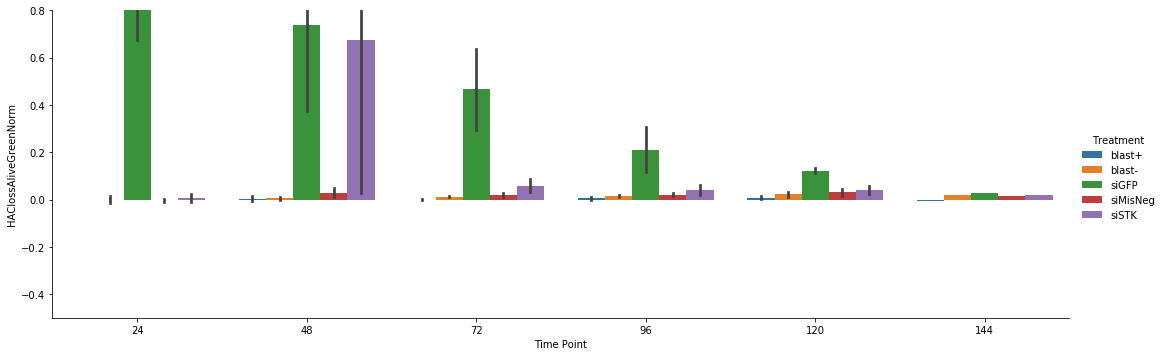

In [35]:
g6 = sns.catplot(x = "Time Point", 
                 y = "HAClossAliveGreenNorm", 
                 #col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech, 
                 kind = "bar", 
                 aspect = 3)

g6.set(ylim=(-0.5, 0.8))

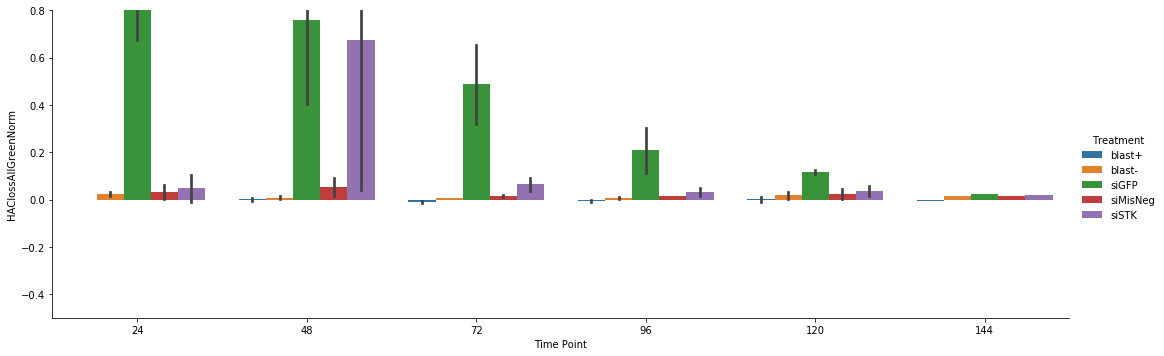

In [36]:
g7 = sns.catplot(x = "Time Point", 
                 y = "HAClossAllGreenNorm", 
                 #col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech, 
                 kind = "bar", 
                 aspect = 3)

g7.set(ylim=(-0.5, 0.8))

# HAC loss focus on 72h

In [37]:
df_counts_gb_alive_green_avg_tech_72h = df_counts_gb_alive_green_avg_tech[df_counts_gb_alive_green_avg_tech['Time Point'] == 72]

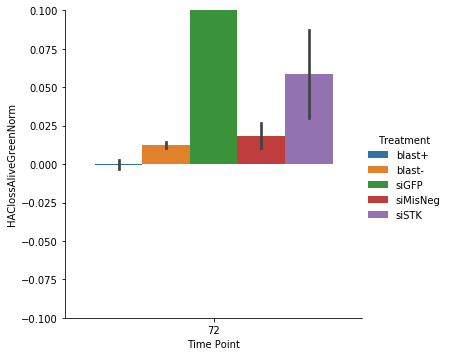

In [38]:
g8 = sns.catplot(x = "Time Point", 
                 y = "HAClossAliveGreenNorm", 
                 #col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech_72h, 
                 kind = "bar", 
                 aspect = 1)
g8.set(ylim=(-0.1, 0.1))

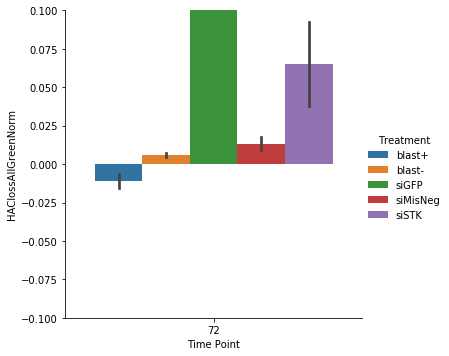

In [39]:
g9 = sns.catplot(x = "Time Point", 
                 y = "HAClossAllGreenNorm", 
                 #col = "Biological Replicate",
                 hue = 'Treatment', 
                 data = df_counts_gb_alive_green_avg_tech_72h, 
                 kind = "bar", 
                 aspect = 1)

g9.set(ylim=(-0.1, 0.1))